In [155]:
from Bio import SeqIO
import primer3
import numpy as np
from IPython.core.debugger import set_trace
import drawSvg as draw
from IPython.display import display

In [2]:
class Primer():
    """
    Class to hold all information regarding a specific primer
    
    Args:
    - seq (str) - string containing the primer sequence to be used
    - dna_conc (float) - concentration (nM) of oligo to use for Tm analysis, default is 250
    - mv_conc (float) - concentration (mM) of monovalent cations to use for Tm analysis, default is 50
    - dv_conc (float) - concentration (mM) of divalent cations to use for Tm analysis, default is 0
    - dntp_conc (float) - concentration (mM) of dNTPs to use for Tm analysis, default is 0
    """
    
    def __init__(self, seq, dna_conc=250, mv_conc=50, dv_conc=0, dntp_conc=0):
        # Convert the sequence to uppercase
        seq = seq.upper()
        
        # Set the sequence to an instance variable
        self.seq = seq
        
        # Set the length variable
        self.length = len(seq)
        
        # Set the standard IDT OligoAnalyzer settings for analysis by primer3
        self.thermo_settings = primer3.thermoanalysis.ThermoAnalysis(dna_conc, mv_conc, dv_conc, dntp_conc)
        
        # Get the Tm of the oligo
        self.Tm = self.thermo_settings.calcTm(self.seq)
        
        # Get hairpin and homodimer properties
        self.hairpin()
        self.homodimer()
        
    def hairpin(self):
        """
        Calculate hairpin properties of the oligo sequence
        """
        hairpin_result = self.thermo_settings.calcHairpin(self.seq)
        self.hairpin = hairpin_result.structure_found
        self.hairpin_Tm = hairpin_result.tm
        
    def homodimer(self):
        """
        Calculate homodimer properties of the oligo sequence
        """
        homodimer_result = self.thermo_settings.calcHomodimer(self.seq)
        self.homodimer = homodimer_result.structure_found
        self.homodimer_Tm = homodimer_result.tm
        
    def rc(self):
        comp = {
            'A': 'T',
            'C': 'G',
            'G': 'C',
            'T': 'A'
        }
        
        self.seq = "".join([comp[nt] for nt in self.seq[::-1]])
        
    def report(self):
        details = OrderedDict({
            'length': len(self.seq),
            'Tm': round(self.Tm, 2),
            'start': self.start,
            'end': self.end,
            'hairpin_Tm': round(self.hairpin_Tm, 2),
            'homodimer_Tm': round(self.homodimer_Tm, 2)
        })
        
        return details
    
    def __repr__(self):
        return 'Seq: {}; Tm: {:.2f}'.format(self.seq, self.Tm)
    
    def __str__(self):
        return self.__repr__()

In [183]:
class Oligo():
    def __init__(self, template_seq, upstream_primer, downstream_primer):
        self.upstream_primer = upstream_primer
        self.downstream_primer = downstream_primer
        
        self.start = self.upstream_primer.start
        self.end = self.downstream_primer.end
        self.seq = template_seq[self.start:self.end]
        
        self.window_start = self.upstream_primer.end
        self.window_end = self.downstream_primer.start
        self.window_seq = template_seq[self.window_start:self.window_end]
        
    def __repr__(self):
        return '<Oligo ({}:{}-{}:{}) F: {:.2f}C, R: {:.2f}C>'.format(self.start, self.window_start,
                                                            self.window_end, self.end, self.upstream_primer.Tm,
                                                            self.downstream_primer.Tm)
    
    def __str__(self):
        return self.__repr__()
    
    
    
def make_primer_with_tm(seq, end_pos, target_tm=60, rc=False):
    primer_tm = 0
    n = 0
    while primer_tm < target_tm:
        n += 1
        primer_start = end_pos - n
        primer_site = str(seq[(primer_start):end_pos].seq)
        primer = Primer(primer_site)
        if rc:
            primer.rc()
        primer.start = primer_start
        primer.end = end_pos
        primer_tm = primer.Tm
        
    return(primer)

In [217]:
class LibDiagram():
    def __init__(self, lib, lib_index, width = 400, height = 200):
        self.lib = lib
        
        self.oligos = lib.libraries[lib_index]
        
        self.dna_h = height / (1.1*(len(self.oligos)+1) - 0.1)
        self.buffer = 0.1 * self.dna_h
        
        self.width = width
        self.height = height
        
        self.draw_background()
        self.draw_template()
        self.draw_lib()
        
    def scale_x(self, nt_width):
        construct_length = len(self.lib.construct)
        nt_px = construct_length / self.width
        return (nt_width / nt_px)
    
    def scale_y(self, obj_index):
        offset = obj_index + 1
        y_offset = (offset * self.dna_h) + (self.buffer * offset)
        return(y_offset)
        
    def draw_background(self):
        self.d = draw.Drawing(self.width, self.height)

    def draw_template(self):
        self.d.append(draw.Rectangle(0, 0, self.scale_x(len(self.lib.construct)), self.dna_h, fill='#D3D3D3'))
        self.d.append(draw.Rectangle(self.scale_x(self.lib.start), 0, self.scale_x(len(self.lib.roi)), self.dna_h, fill='#0000CC'))
        
    def draw_oligo(self, oligo, y_offset):
        primer1 = draw.Rectangle(self.scale_x(oligo.start), y_offset, self.scale_x(oligo.window_start - oligo.start), self.dna_h, fill='#FFA500')
        primer2 = draw.Rectangle(self.scale_x(oligo.window_end), y_offset, self.scale_x(oligo.end - oligo.window_end), self.dna_h, fill='#FFA500')
        window = draw.Rectangle(self.scale_x(oligo.window_start), y_offset, self.scale_x(oligo.window_end - oligo.window_start), self.dna_h, fill='#000000')
        self.d.append(primer1)
        self.d.append(primer2)
        self.d.append(window)
        
    def draw_lib(self):
        for i, oligo in enumerate(self.oligos):
            self.draw_oligo(oligo, self.scale_y(i))
        
    def plot(self):
        display(self.d)

In [242]:
class Library():
    def __init__(self, fasta, start, end, oligo_size, primer_min_length=16, primer_max_length=30,
                 primer_min_tm=58, primer_max_tm=62, primer_target_tm=60):
        self.start = start
        self.end = end
        self.primer_min_length = primer_min_length
        self.primer_max_length = primer_max_length
        self.primer_min_tm = primer_min_tm
        self.primer_max_tm = primer_max_tm
        self.primer_target_tm = primer_target_tm
        self.oligo_size = oligo_size
        self.construct = list(SeqIO.parse(fasta, 'fasta'))[0]
        self.roi = self.construct[start:end]
        self.breakpoints = [x + self.start for x in range(end - start) if x % 3 == 0] + [i for i in range(self.end, len(self.construct))]
        self.libraries = []
        
        self.max_oligos = 0

    def make_primer_with_tm(self, seq, start_pos, rc=False):
        # Set the initial Tm to 0 and the nucleotide distance to 0
        primer_tm = -np.inf
        n = self.primer_min_length
        current_diff = abs(primer_tm - self.primer_target_tm)
        
        primers = []
        primer_tms = []

        # Keep extending until the target Tm threshold is reached
        while n <= self.primer_max_length:

            # Add a nucleotide in length
            n += 1

            # Get the primer
            primer_end = start_pos + n
            primer_site = str(seq[start_pos:primer_end].seq)
            primer = Primer(primer_site)
            primers.append(primer)

            # Reverse complement if need reverse primer
            if rc:
                primer.rc()

            # Add start and end position data
            primer.start = start_pos
            primer.end = primer_end

            # Extract the Tm
            primer_tm = primer.Tm
            primer_tms.append((primer_tm - self.primer_target_tm)**2)
                
        return(primers[np.argmin(primer_tms)])
        
    def get_first_oligos(self):
        
        start_oligos = []
        
        for bp in self.breakpoints[1:]:
            window_end = bp
            downstream_primer = self.make_primer_with_tm(self.construct, window_end, rc=True)
            oligo_end = downstream_primer.end
            oligo_start = oligo_end - self.oligo_size
            
            if oligo_start < 0:
                continue
                
            upstream_primer = self.make_primer_with_tm(self.construct, oligo_start, rc = True)
            
            up_valid_length = self.primer_min_length <= upstream_primer.length <= self.primer_max_length
            dp_valid_length = self.primer_min_length <= upstream_primer.length <= self.primer_max_length
            
            if oligo_start < 0 or not up_valid_length or not dp_valid_length:
                continue
            
            if upstream_primer.end > self.start:
                break
                
            if self.primer_in_tm_range(upstream_primer) and self.primer_in_tm_range(downstream_primer):
                oligo = Oligo(self.construct, upstream_primer, downstream_primer)
                start_oligos.append(oligo)
                
        return start_oligos
    
    def define_primers(self, oligo_start, window_start, window_end, oligo_end):
        upstream_primer = Primer(str(self.construct[oligo_start:window_start].seq))
        upstream_primer.start = oligo_start
        upstream_primer.end = window_start
        
        downstream_primer = Primer(str(self.construct[window_end:oligo_end].seq))
        downstream_primer.start = window_end
        downstream_primer.end = oligo_end
        
        return upstream_primer, downstream_primer
    
    def primer_in_tm_range(self, primer):
        return self.primer_min_tm <= primer.Tm <= self.primer_max_tm

    def create_next_oligo(self, oligos):
        
        last_oligo = oligos[-1]
        
        window_start = last_oligo.window_end
        
        for window_end in self.breakpoints:
            window_size = window_end - window_start
            valid_window = window_size > 0 
            valid_size = self.primer_min_length <= ((self.oligo_size - window_size) / 2) <= self.primer_max_length
            
            oligo_end = window_end + self.primer_min_length
            oligo_start = oligo_end - self.oligo_size
            
            if valid_window and valid_size:
                
#                 print("Oligos:", len(oligos))
                up_length = window_start - oligo_start
            
                while up_length >= self.primer_min_length:
                    upstream_primer, downstream_primer = self.define_primers(oligo_start, window_start, window_end, oligo_end)
                    
                    up_valid = self.primer_min_length <= window_start - oligo_start <= self.primer_max_length
                    dp_valid = self.primer_min_length <= oligo_end - window_end <= self.primer_max_length

                    if self.primer_in_tm_range(upstream_primer) and self.primer_in_tm_range(downstream_primer) and up_valid and dp_valid:
                        oligo = Oligo(self.construct, upstream_primer, downstream_primer)
                        path = oligos.copy()
                        path.append(oligo)

                        if window_end > self.end:
                            self.libraries.append(path)
                            print("Valid libraries found:", len(self.libraries))
                            print("Num oligos:", len(path))
                        else:
                            self.create_next_oligo(path)
                            
                    else:
                        if len(oligos) > 3 and len(oligos) > self.max_oligos:
                            print("Search truncated at {} oligos, invalid primer Tms: {} {:.2f}, {} {:.2f}".format(len(oligos), upstream_primer.length, upstream_primer.Tm, downstream_primer.length, downstream_primer.Tm))
                            self.max_oligos = len(oligos)

                    oligo_start += 1
                    oligo_end += 1

                    up_length = window_start - oligo_start
                    
                    
    def design_lib(self):
        first_oligos = self.get_first_oligos()
        
        for starting_point in first_oligos:
            oligos = [starting_point]
            self.create_next_oligo(oligos)
            
    def score_libs(self):
        
        best_lib_score = np.inf
        
        for i, lib in enumerate(self.libraries):
            lib_length = len(lib)
            
            lib_tms = []
            for oligo in lib:
                lib_tms.extend([oligo.upstream_primer.Tm, oligo.downstream_primer.Tm])
                
            rse_tm = np.sqrt(sum([(tm - self.primer_target_tm)**2 for tm in lib_tms]))
            rmse_tm = rse_tm / len(lib_tms)
            
            if rse_tm < best_lib_score:
                best_lib_score = rse_tm
                print("RSE Tm: {:.2f}, RMSE Tm: {:.2f}".format(rse_tm, rmse_tm))
                self.best_lib_index = i
                self.best_lib = lib
                
        LibDiagram(self, self.best_lib_index).plot()

In [243]:
lib = Library('myc_dhfr_ivtt.fa', 155, 629, 230, primer_min_tm=59, primer_max_tm=61, primer_target_tm=60)
lib.design_lib()
lib.score_libs()

Valid libraries found: 1
Num oligos: 4
Valid libraries found: 2
Num oligos: 4
Valid libraries found: 3
Num oligos: 4
Valid libraries found: 4
Num oligos: 4
Valid libraries found: 5
Num oligos: 3
Valid libraries found: 6
Num oligos: 3
Valid libraries found: 7
Num oligos: 3
Valid libraries found: 8
Num oligos: 3
Valid libraries found: 9
Num oligos: 3
Valid libraries found: 10
Num oligos: 3
Valid libraries found: 11
Num oligos: 3
Valid libraries found: 12
Num oligos: 3
Valid libraries found: 13
Num oligos: 3
Valid libraries found: 14
Num oligos: 3


KeyboardInterrupt: 

Search truncated at 4 oligos, invalid primer Tms: 43 59.14, 16 32.42
Search truncated at 5 oligos, invalid primer Tms: 43 61.19, 16 38.26
Search truncated at 6 oligos, invalid primer Tms: 43 64.29, 16 33.80
Search truncated at 7 oligos, invalid primer Tms: 43 63.74, 16 41.50
Search truncated at 8 oligos, invalid primer Tms: 43 61.09, 16 36.70
Search truncated at 9 oligos, invalid primer Tms: 44 64.39, 16 52.07
Valid libraries found: 1
Num oligos: 10
Valid libraries found: 2
Num oligos: 10
Valid libraries found: 3
Num oligos: 10
Valid libraries found: 4
Num oligos: 10
RSE Tm: 2.41, RMSE Tm: 0.12
RSE Tm: 2.37, RMSE Tm: 0.12


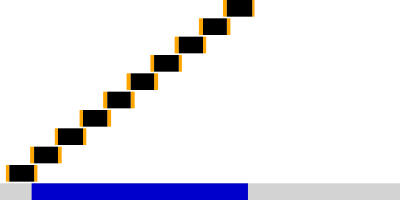

In [244]:
lib = Library('pafa_ivtt.fa', 231, 1810, 230, primer_min_tm=54.5, primer_max_tm=56, primer_target_tm=55)
lib.design_lib()
lib.score_libs()

In [246]:
lib.best_lib

[<Oligo (43:68-249:273) F: 54.70C, R: 55.82C>,
 <Oligo (220:249-423:450) F: 55.28C, R: 55.63C>,
 <Oligo (400:423-606:630) F: 54.64C, R: 55.02C>,
 <Oligo (581:606-783:811) F: 54.85C, R: 54.50C>,
 <Oligo (753:783-954:983) F: 54.88C, R: 55.70C>,
 <Oligo (924:954-1125:1154) F: 55.65C, R: 54.71C>,
 <Oligo (1098:1125-1305:1328) F: 54.77C, R: 55.72C>,
 <Oligo (1275:1305-1482:1505) F: 55.47C, R: 55.57C>,
 <Oligo (1452:1482-1656:1682) F: 55.47C, R: 55.53C>,
 <Oligo (1628:1656-1841:1858) F: 55.86C, R: 55.79C>]

In [236]:
primers = [
    'GGGTTATTGTCTCATGAGCG',
    'CGAAAAGTGCTAGTGGTGC',
    'CGAAATTAATACGACTCACTATAGGG',
    'CGAAATTAATACGACTCACTATAGGG',
    'GAAGGAGGTTTTAAGAGAATGC',
    'GTCTATATGAACATTATTTAACGAATACCC',
    'AAGAATTAGGGAAAAGTGTTTACTG',
    'CCAACCGAGTTAGAAGTAGTTCC',
    'AGCATCAATTCTGCCTGC',
    'ATCGAACCAAAATGCTCC',
    'CCCATTAATCAGTATACAGAAAGC',
    'ATAAACCTTCCCATTCCACA',
    'AGATGCTGCAATTGATGG',
    'GGAAGTCAGTAATATCATCAACTCC',
    'TGGCTGACTTCTTCAATAACC',
    'CGCAGAAAGGAATACAAGG',
    'TCGGTGCTGATAATATAATTGC',
    'AAATAAACCTGATAGTTCATCGC',
    'GGATGAAATCTGGGAATCG',
    'CCAGTTATAACCATTGATTACTCTGG',
    'GGAACTCTTATGATTCACATATTCC',
    'GGCTGATTGGACTCTCCC',
    'CCTTGCTCACCATGCC',
    'CAAAAAACCCCTCAAGACC',
    'GCTTCCGGATATAGTTCCTCC',
    'TTGAGTGAGCTGATACCGC']

for primer in primers:
    print(Primer(primer).Tm)

52.49924914448957
53.311752407916
52.94507529573758
52.94507529573758
51.03066559742081
52.64857936927484
51.35388105596854
54.33201040541047
52.113947719940484
49.381386899456515
51.1446534821892
50.18216355227361
49.403899917518004
52.68299348805954
51.87122317789948
50.1327135011291
50.4528034484058
50.97522922726256
49.503845782530846
53.15701177490263
51.246177587002535
53.07137661255922
51.55543712671124
50.33188217487043
53.40371599944541
53.54402568828402
